In [177]:
%pylab inline --no-import-all
import seaborn as sns
import scipy as sp
import scipy.ndimage
from sklearn.neural_network import MLPClassifier
import os

Populating the interactive namespace from numpy and matplotlib


Downloading MNIST datased

**P.S.: it takes about 10+ MB, so this can take some time**

In [262]:
import requests
import gzip
from pathlib import Path

urls = [
    "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
    "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
    "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
    "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"
]

paths = [
    "/tmp/train_images",
    "/tmp/train_labels",
    "/tmp/test_images",
    "/tmp/test_labels"
]

def check_exist(path_to_file):
    file = Path(path_to_file)
    return file.exists()

for path, url in zip(paths, urls):
    if not check_exist(path) or not os.path.getsize(path):
        print("downloading " + url)
        response = requests.get(url)
        with open(path, "wb") as f:
            print("writing to" + path)
            f.write(gzip.decompress(response.content))

In [263]:
import os, struct
from array import array

def read_mnist(digits, fname_img, fname_lbl):
    flbl = open(fname_lbl, 'rb')
    magic_nr, size = struct.unpack(">II", flbl.read(8))
    lbl = array("b", flbl.read())
    flbl.close()

    fimg = open(fname_img, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = array("B", fimg.read())
    fimg.close()

    ind = [ k for k in range(size) if lbl[k] in digits ]
    images =  np.zeros((len(ind), rows*cols))
    labels = np.zeros((len(ind), 1))
    for i in range(len(ind)):
        images[i, :] = list(img[ ind[i]*rows*cols : (ind[i]+1)*rows*cols ])
        labels[i] = lbl[ind[i]]

    return images, labels

Read MNIST dataset and convert result to numpy arrays

In [250]:
train_images, train_labels = read_mnist(list(range(0, 10)), paths[0], paths[1])
test_images, test_labels = read_mnist(list(range(0, 10)), paths[2], paths[3])
images = np.vstack((train_images, test_images))  # put it together for similar filtering
labels = np.vstack((train_labels, test_labels))

Let's try to clean our images by morphology and thresholding

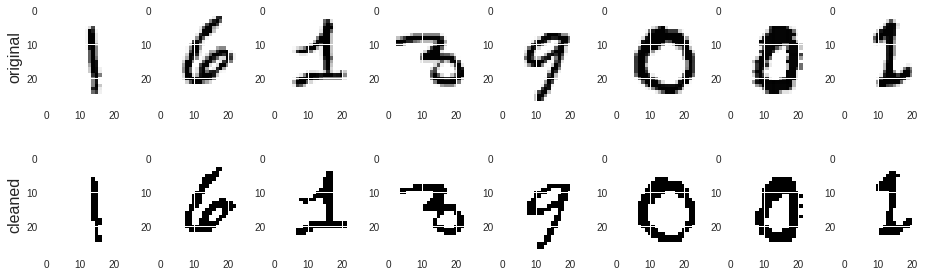

In [251]:
clean_images = np.apply_along_axis(lambda arr: sp.ndimage.grey_erosion(arr.reshape((28, 28)), size=(2,2)).reshape(28*28),
                           1, images)
threshold = 20
clean_images = np.where(clean_images > threshold, 1, 0).astype(int)
examples = 8
fig, axes = plt.subplots(2, examples, figsize=(16, 5))
for col in range(examples):
    ex = col * 10 + np.random.randint(0, 10)
    axes[0, col].imshow(images[ex].reshape(28, 28))
    axes[1, col].imshow(clean_images[ex].reshape(28, 28))
    
axes[0, 0].set_ylabel("original", size=16)
axes[1, 0].set_ylabel("cleaned", size=16)

Split data to train and test sets

In [252]:
trainX, testX = np.split(clean_images, [60000])
trainY, testY = np.split(labels.astype(int), [60000])

Create multilayer perceptron classifier

In [254]:
clf = MLPClassifier(hidden_layer_sizes=(100, 100, 1000))

Train the classifier

In [255]:
clf.fit(trainX, trainY.reshape(trainY.shape[0]))

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100, 1000), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

Predict on test set and check predictions accuracy

In [258]:
predictions = clf.predict(testX)

print("Accuracy is {:.2f}%".format(100 * np.sum(predictions == testY.reshape(testY.shape[0])) / predictions.shape[0]))

Accuracy is 96.92%


Now let's see how frequently certain digits were not recognized and what's was recognized instead 

In [259]:
def what_is_predicted(predictions, instead_of):
    return predictions[np.all(
        (predictions.reshape(predictions.shape[0], 1) != testY, testY == instead_of),
        axis=0).reshape(predictions.shape)]

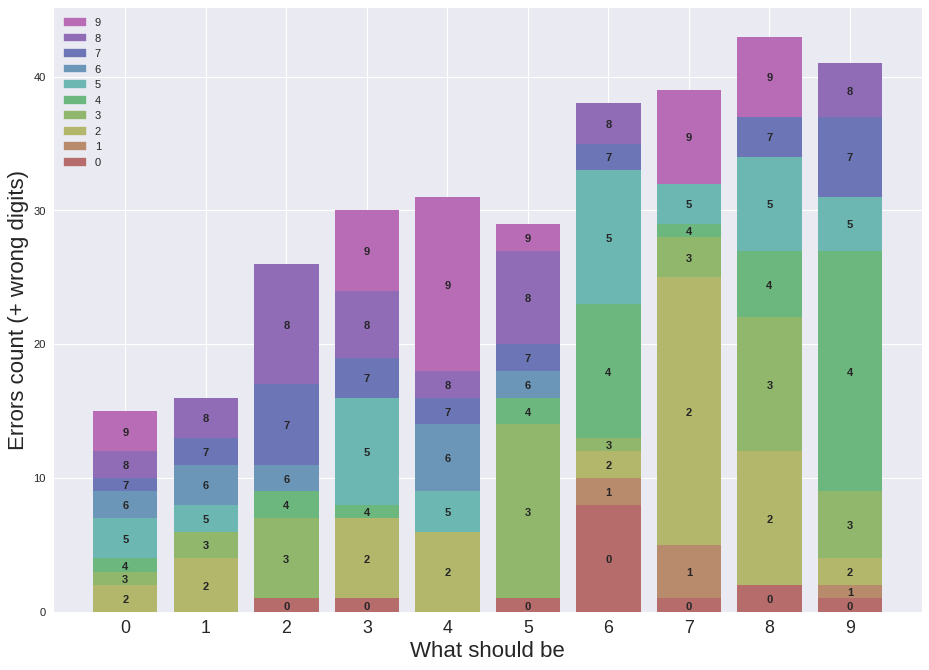

In [260]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(14, 10), dpi=80)
colors = [
    "#B76C6C",
    "#B78B6C",
    "#B3B76C",
    "#90B76C",
    "#6CB77E",
    "#6CB7B2",
    "#6C96B7",
    "#6C76B7",
    "#906CB7",
    "#B76CB5"
]
plt.xticks(np.arange(10), size=16)
plt.xlabel("What should be", size=20)
plt.ylabel("Wrong predictions", size=20)


wrong_numbers = [np.bincount(what_is_predicted(predictions, i)) for i in range(0, 10)]
result = []
for i, num in enumerate(wrong_numbers):
    bottom = 0
    for j, error in enumerate(num):
        if error:
            result.append(ax.bar(i, error, bottom=bottom, color=colors[j]))       
            ax.text(i, bottom + error*0.5 - 0.1, j,
                    verticalalignment='center',
                    horizontalalignment='center',
                    size=10, weight='bold')
            
            bottom += error
            
ax.legend(handles = [mpatches.Patch(color=colors[i], label=i) for i in reversed(range(10))])

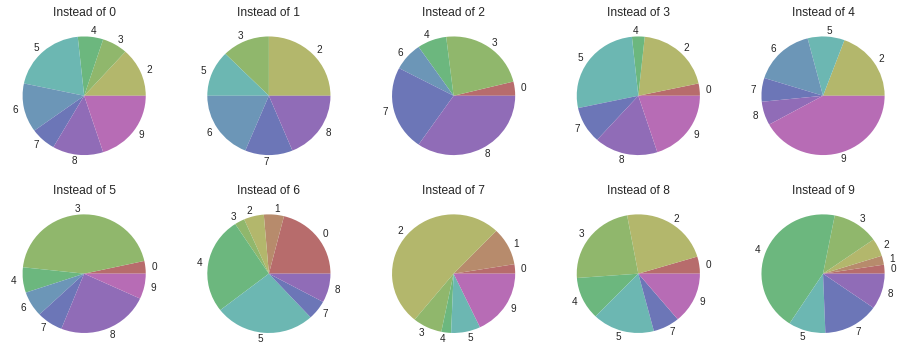

In [261]:
fig, axes = plt.subplots(2, 5, figsize=(16, 6))

for i, num in enumerate(wrong_numbers):
    position = (int(i > 4), i % 5)
    labels = list(map(lambda x: str(x) if num[x] > 0 else "", list(range(len(num)))))
    axes[position].pie(num, labels=labels, colors=colors)
    axes[position].set_title("Instead of {:d}".format(i))
